**Missing Value** - No information for the recipients that are Merchants, but there were no fraud cases in the data regarding PAYMENT type and Merchants, hence we simply drop these rows from our dataset.

**Outliers** - Since the outliers are common in monetary dataset, they might be meaningful hence not rectified, instead Outlier friendly modelling, viz., Random Forest or Gradient Boost Classifier can be used. In this case Gradient Boost Classifier is used for modelling.

Outliers are calculated taking into consideration the percentiles, so it is interesting to note that even if outliers are treated new percentiles will be calculated, thereby still forming some extreme values, which are outliers. Hence, model selection is helpful in this scenario.

**Multi-collinearity** - The columns 'oldbalanceOrg' and 'newbalanceOrig' are correlated similar to 'oldbalanceDest' and 'newbalanceDest' which is logical, as these are the before and after numbers left as the transactions take place. Therefore, only one out of the pair is choosen, 'oldbalanceOrg', and 'newbalanceDest' are used as they are directly related to the amount of transaction.

Two new columns are introduced before fropping the above columns, so that the data is not lost. 

a) 'balancedifOrg' = 'oldbalanceOrg' - 'newbalanceOrig' 

b) 'balancedifDest' = 'newbalanceDest' - 'oldbalanceDest'

====================================================================================================================

In [1]:
cdir='D:/WORKS/4. Fraud/'

In [2]:
import os

os.chdir(cdir)

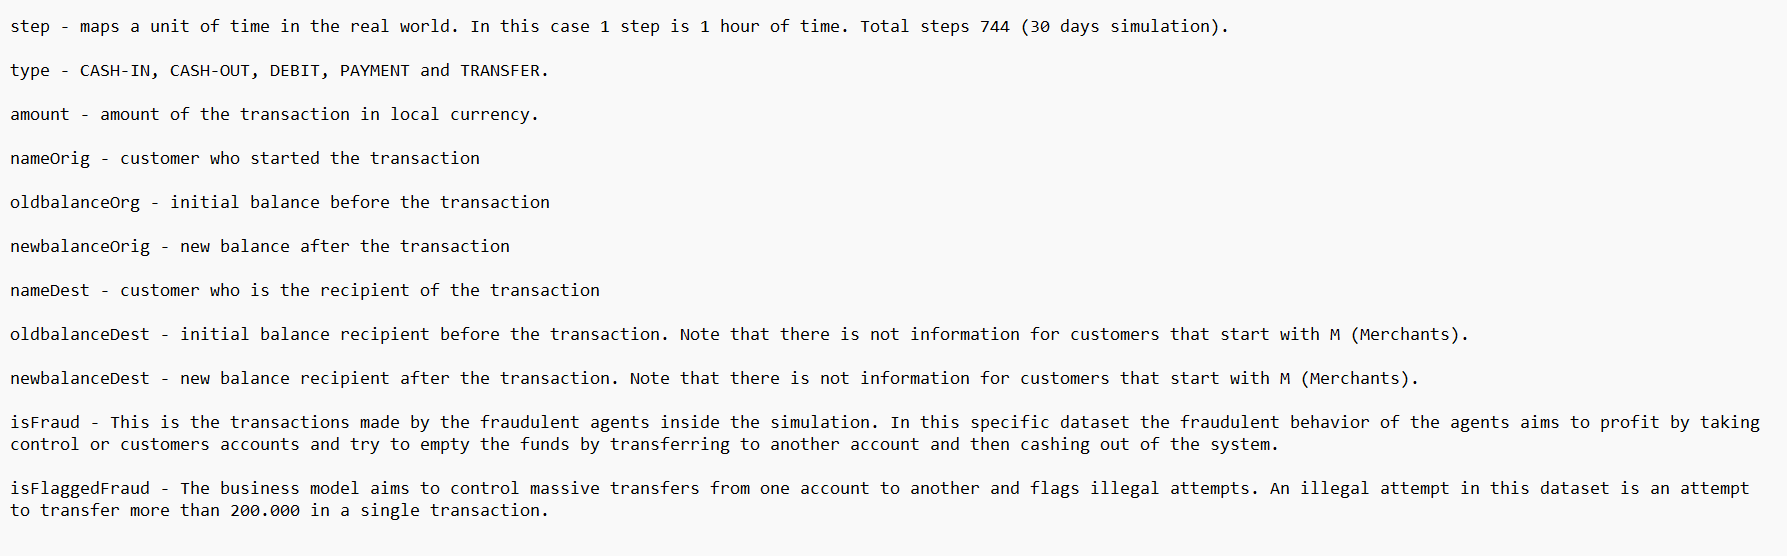

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings as fw
from warnings import simplefilter as sf

%matplotlib inline
fw('ignore')
sf('ignore')

In [4]:
pd.set_option('display.max_rows', 2000)

df = pd.read_csv("Fraud.csv.zip")

df['merchantORnot'] = df['nameDest'].str[0]

df1 = df[df['merchantORnot'] == 'C'].copy()

df1.reset_index(drop=True, inplace=True)

df2 = df[df.merchantORnot == 'M'].copy()

df2.reset_index(drop=True, inplace=True)

df2['isFraud'].value_counts()

0    2151495
Name: isFraud, dtype: int64

In [5]:
df.shape

(6362620, 12)

In [6]:
df1[df1.isFraud==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [7]:
df_1 = df1[(df1.type=='CASH_OUT') | (df1.type=='TRANSFER')].reset_index(drop=True).copy()

In [8]:
df_1.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
merchantORnot     0
dtype: int64

In [9]:
df_1.duplicated().sum()

0

In [10]:
df_1.shape

(2770409, 12)

In [11]:
df_1['name'] = df_1['nameOrig'].str[0]

In [12]:
df_1['name'].value_counts()

C    2770409
Name: name, dtype: int64

In [13]:
df_1['type'].value_counts(normalize=True)

CASH_OUT    0.807642
TRANSFER    0.192358
Name: type, dtype: float64

In [14]:
df_1[df_1['isFraud'] == 1]['type'].value_counts(normalize=True)

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

In [15]:
df_1[pd.get_dummies(df_1.type).columns] = pd.get_dummies(df_1.type)

In [16]:
df_1.isFraud.value_counts(normalize=True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

In [17]:
df_1['balancedifOrg'] = df_1['oldbalanceOrg'] - df_1['newbalanceOrig']
df_1['balancedifDest'] = df_1['newbalanceDest'] - df_1['oldbalanceDest']

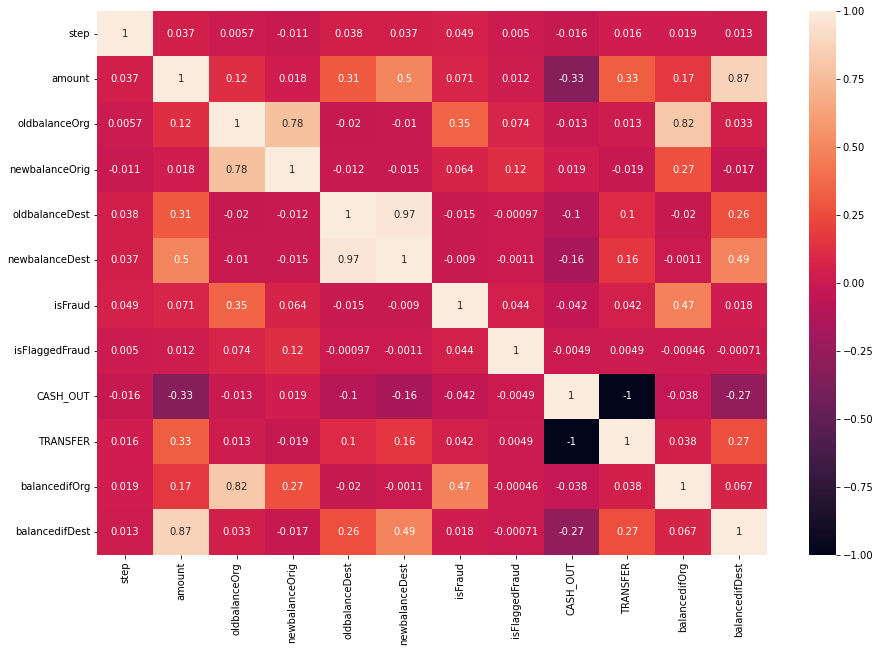

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(df_1.corr(), annot=True);

In [19]:
num = []
obj = []

for col in df_1.columns:
    if df_1[col].dtype != 'object':
        num.append(col)
    else:
        obj.append(col)

In [20]:
df_1.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [21]:
df_2 = df_1[(df_1.amount == df_1.oldbalanceOrg) | (df_1.TRANSFER==1)].copy()

In [22]:
drop_ind = list(df_1[(df_1.amount == df_1.oldbalanceOrg) | (df_1.TRANSFER==1)].index)

test_df = df.loc[~df.index.isin(drop_ind)].reset_index(drop = True).copy()

In [23]:
df_2.isFraud.value_counts()

0    528812
1      8188
Name: isFraud, dtype: int64

In [24]:
df_2.reset_index(drop=True, inplace=True)

In [25]:
del df1
del df2
del df

In [26]:
keep_cols = ['amount', 'oldbalanceOrg', 'newbalanceDest', 'isFraud', 'CASH_OUT', 'TRANSFER', 'balancedifOrg', 
             'balancedifDest']

In [27]:
df_1 = df_1[keep_cols].copy()

In [28]:
df_2[df_2['balancedifOrg']<0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchantORnot,name,CASH_OUT,TRANSFER,balancedifOrg,balancedifDest


In [29]:
df_1[df_1['balancedifOrg']<0]

,amount,oldbalanceOrg,newbalanceDest,isFraud,CASH_OUT,TRANSFER,balancedifOrg,balancedifDest
11032,88553.31,67106.46,0.00,0,1,0,-21446.85,-67106.46
11385,106659.84,80084.58,92322.89,0,1,0,-26575.26,12238.31


In [30]:
Jplot = ['amount', 'oldbalanceOrg', 'newbalanceDest', 'balancedifOrg', 'balancedifDest']

**Train Test Split**

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = df_1.drop(['CASH_OUT','isFraud'], axis=1)
Y = df_1['isFraud']

In [33]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size = 0.2, random_state=11)

**Machine Learning**

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [35]:
GBC = GradientBoostingClassifier(random_state=21, verbose=1, max_depth=4, n_estimators=71, max_features=3)

In [36]:
GBC.fit(X_tr, Y_tr)

      Iter       Train Loss   Remaining Time 
         1           0.0256           11.37m
         2           0.2792           10.53m
         3       25090.1486           10.62m
         4 136420401582610054051587610523050931975618560.0000           10.98m
         5 136420401582610054051587610523050931975618560.0000           10.76m
         6 136420401582610054051587610523050931975618560.0000           10.48m
         7 136420401582610054051587610523050931975618560.0000           10.34m
         8 136420401582610054051587610523050931975618560.0000           10.09m
         9 136420401582610054051587610523050931975618560.0000            9.94m
        10 136420401582610054051587610523050931975618560.0000            9.81m
        20 4972244736704389281579019804567967863284278402337714725586306850048966656.0000            7.98m
        30 4972244736704389281579019804567967863284278402337714725586306850048966656.0000            6.35m
        40 49722447367043892815790198045679678632842

GradientBoostingClassifier(max_depth=4, max_features=3, n_estimators=71,
                           random_state=21, verbose=1)

**High Loss value is because of the imbalance in the dataset**

In [37]:
GBC.score(X_tr, Y_tr)

0.9977097242419553

In [38]:
GBC.score(X_te, Y_te)

0.9976447529427053

In [39]:
ypred1 = GBC.predict(X_tr)
print(confusion_matrix(Y_tr, ypred1))
print(classification_report(Y_tr, ypred1))

[[2208177    1630]
 [   3446    3074]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2209807
           1       0.65      0.47      0.55      6520

    accuracy                           1.00   2216327
   macro avg       0.83      0.74      0.77   2216327
weighted avg       1.00      1.00      1.00   2216327



In [40]:
ypred2 = GBC.predict(X_te)
print(confusion_matrix(Y_te, ypred2))
print(classification_report(Y_te, ypred2))

[[551972    417]
 [   888    805]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552389
           1       0.66      0.48      0.55      1693

    accuracy                           1.00    554082
   macro avg       0.83      0.74      0.78    554082
weighted avg       1.00      1.00      1.00    554082



In [41]:
pd.DataFrame(GBC.feature_importances_, index=X_tr.columns, columns=['Importance']).sort_values(by='Importance', 
                                                                                                      ascending=False)

,Importance
balancedifOrg,0.325859
TRANSFER,0.255571
balancedifDest,0.136712
oldbalanceOrg,0.124864
newbalanceDest,0.096728
amount,0.060267


**Transform - Modelling**

In [42]:
from sklearn.preprocessing import PowerTransformer

In [43]:
PT1 = PowerTransformer()

In [44]:
X_tr.reset_index(drop=True, inplace=True)
X_te.reset_index(drop=True, inplace=True)

In [45]:
X_tr_tf1 = pd.DataFrame(PT1.fit_transform(X_tr[Jplot]), columns = Jplot)
X_te_tf1 = pd.DataFrame(PT1.transform(X_te[Jplot]), columns = Jplot)

In [46]:
X_tr_tf1['TRANSFER'] = X_tr['TRANSFER']
X_te_tf1['TRANSFER'] = X_te['TRANSFER']

In [47]:
GBC_tf = GradientBoostingClassifier(random_state=21, verbose=1, max_depth=4, n_estimators=71, max_features=3)

In [48]:
GBC_tf.fit(X_tr_tf1, Y_tr)

      Iter       Train Loss   Remaining Time 
         1           0.0210           10.33m
         2      878858.4357            9.04m
         3      878858.4353            8.71m
         4      878858.4348            8.83m
         5      878858.4343            8.77m
         6      878858.4339            8.67m
         7      878858.4336            8.68m
         8      878626.5862            8.65m
         9      878628.2289            8.54m
        10      878628.1919            8.30m
        20 1438600117435864897855439755657953658368029622272.0000            7.52m
        30 239766686239310829830846361710772559026172461056.0000            6.10m
        40 32294082331711739220201184428032.0000            4.69m
        50 3852765193011060843530082933823032776626170899747156927709184.0000            3.22m
        60 3852765193011060843530082933823032776626170899747156927709184.0000            1.74m
        70 3852765193011060843530082933823032776626170899747156927709184.0000      

GradientBoostingClassifier(max_depth=4, max_features=3, n_estimators=71,
                           random_state=21, verbose=1)

**Transforming still didn't help**

In [49]:
GBC_tf.score(X_tr_tf1, Y_tr)

0.9984266762079783

In [50]:
GBC_tf.score(X_te_tf1, Y_te)

0.9984009587028635

In [51]:
GBC_tf.score(X_tr_tf1, Y_tr) - GBC_tf.score(X_te_tf1, Y_te)

2.5717505114819517e-05

In [52]:
ypred1_tf = GBC_tf.predict(X_tr_tf1)
print(confusion_matrix(Y_tr, ypred1_tf))
print(classification_report(Y_tr, ypred1_tf))

[[2209037     770]
 [   2717    3803]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2209807
           1       0.83      0.58      0.69      6520

    accuracy                           1.00   2216327
   macro avg       0.92      0.79      0.84   2216327
weighted avg       1.00      1.00      1.00   2216327



In [53]:
ypred2_tf = GBC_tf.predict(X_te_tf1)
print(confusion_matrix(Y_te, ypred2_tf))
print(classification_report(Y_te, ypred2_tf))

[[552188    201]
 [   685   1008]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552389
           1       0.83      0.60      0.69      1693

    accuracy                           1.00    554082
   macro avg       0.92      0.80      0.85    554082
weighted avg       1.00      1.00      1.00    554082



In [54]:
pd.DataFrame(GBC_tf.feature_importances_, index=X_tr_tf1.columns, columns=['Importance']).sort_values(by='Importance', 
                                                                                                      ascending=False)

,Importance
balancedifDest,0.385930
balancedifOrg,0.230393
TRANSFER,0.185861
oldbalanceOrg,0.101682
newbalanceDest,0.065908
amount,0.030226


====================================================================================================================

**OVERSAMPLING - SMOTE**

**BEST MODEL**

In [55]:
from imblearn.over_sampling import SMOTE

In [56]:
oversample = SMOTE(random_state=27)
X_, Y_ = oversample.fit_resample(X, Y)

In [57]:
X_tr_, X_te_, Y_tr_, Y_te_ = train_test_split(X_, Y_, test_size=0.2, random_state=11)

In [58]:
GBC_ = GradientBoostingClassifier(random_state=27, verbose=1, max_depth=4, n_estimators=71, max_features=3)

In [59]:
GBC_.fit(X_tr_, Y_tr_)

      Iter       Train Loss   Remaining Time 
         1           1.2340           22.08m
         2           1.1106           21.94m
         3           1.0043           22.85m
         4           0.9119           22.29m
         5           0.8404           24.79m
         6           0.7742           25.29m
         7           0.7182           24.81m
         8           0.6670           23.90m
         9           0.6201           23.15m
        10           0.5810           23.70m
        20           0.3532           21.49m
        30           0.2608           15.34m
        40           0.2169           10.75m
        50           0.1910            6.98m
        60           0.1678            3.56m
        70           0.1531           18.78s


GradientBoostingClassifier(max_depth=4, max_features=3, n_estimators=71,
                           random_state=27, verbose=1)

In [60]:
pred1 = GBC_.predict(X_tr_)
print(GBC_.score(X_tr_, Y_tr_))
print(confusion_matrix(Y_tr_, pred1))
print(classification_report(Y_tr_, pred1))

0.9804145841408318
[[2133970   75875]
 [  10683 2198985]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   2209845
           1       0.97      1.00      0.98   2209668

    accuracy                           0.98   4419513
   macro avg       0.98      0.98      0.98   4419513
weighted avg       0.98      0.98      0.98   4419513



In [61]:
pred2 = GBC_.predict(X_te_)
print(GBC_.score(X_te_, Y_te_))
print(confusion_matrix(Y_te_, pred2))
print(classification_report(Y_te_, pred2))

0.9804304362740174
[[533390  18961]
 [  2661 549867]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552351
           1       0.97      1.00      0.98    552528

    accuracy                           0.98   1104879
   macro avg       0.98      0.98      0.98   1104879
weighted avg       0.98      0.98      0.98   1104879



In [62]:
pd.DataFrame(GBC_.feature_importances_, index=X_tr_.columns, columns=['Importance']).sort_values(by='Importance', 
                                                                                                      ascending=False)

,Importance
balancedifOrg,0.394724
oldbalanceOrg,0.214626
newbalanceDest,0.162915
balancedifDest,0.126924
amount,0.083977
TRANSFER,0.016834


**SMOTE is itself a kind of transformation, therefore no prior transformation is necessary**

**Recall of label 1 is maximum and the labels are balanced**

=====================================================================================================================

**Filtering Data Before Modelling**

In [63]:
df_2['isFraud'].value_counts(normalize=True)

0    0.984752
1    0.015248
Name: isFraud, dtype: float64

In [64]:
Jplot = ['amount', 'oldbalanceOrg', 'newbalanceDest', 'balancedifOrg', 'balancedifDest']

In [65]:
X_sel = df_2.drop(['CASH_OUT','isFraud'], axis=1)
Y_sel = df_2['isFraud']

In [66]:
X_sel_tr, X_sel_te, Y_sel_tr, Y_sel_te = train_test_split(X_sel, Y_sel, test_size=0.2, random_state=11, stratify=Y_sel)

In [67]:
PT = PowerTransformer()

In [68]:
X_sel_tr.reset_index(drop=True, inplace=True)
X_sel_te.reset_index(drop=True, inplace=True)

In [69]:
X_sel_tr1 = pd.DataFrame(PT.fit_transform(X_sel_tr[Jplot]), columns=Jplot)
X_sel_te1 = pd.DataFrame(PT.transform(X_sel_te[Jplot]), columns=Jplot)

In [70]:
X_sel_tr1['TRANSFER'] = X_sel_tr['TRANSFER']
X_sel_te1['TRANSFER'] = X_sel_te['TRANSFER']

In [71]:
GBC_sel = GradientBoostingClassifier(random_state=27, verbose=1, max_depth=4, n_estimators=41, max_features=3)

GBC_sel.fit(X_sel_tr1, Y_sel_tr)

      Iter       Train Loss   Remaining Time 
         1           0.0340           52.98s
         2           0.0307           49.88s
         3           0.0278           48.94s
         4           0.0252           47.78s
         5           0.0229           45.18s
         6           0.0209           43.32s
         7           0.0189           41.84s
         8           0.0172           40.66s
         9           0.0157           39.86s
        10           0.0144           38.70s
        20           0.0062           25.61s
        30           0.0031           13.42s
        40           0.0018            1.22s


GradientBoostingClassifier(max_depth=4, max_features=3, n_estimators=41,
                           random_state=27, verbose=1)

In [72]:
pred1_sel = GBC_sel.predict(X_sel_tr1)
print(GBC_sel.score(X_sel_tr1, Y_sel_tr))
print(confusion_matrix(Y_sel_tr, pred1_sel))
print(classification_report(Y_sel_tr, pred1_sel))

0.9999022346368716
[[423017     33]
 [     9   6541]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    423050
           1       0.99      1.00      1.00      6550

    accuracy                           1.00    429600
   macro avg       1.00      1.00      1.00    429600
weighted avg       1.00      1.00      1.00    429600



In [73]:
pred2_sel = GBC_sel.predict(X_sel_te1)
print(GBC_sel.score(X_sel_te1, Y_sel_te))
print(confusion_matrix(Y_sel_te, pred2_sel))
print(classification_report(Y_sel_te, pred2_sel))

0.9998230912476722
[[105750     12]
 [     7   1631]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105762
           1       0.99      1.00      0.99      1638

    accuracy                           1.00    107400
   macro avg       1.00      1.00      1.00    107400
weighted avg       1.00      1.00      1.00    107400



In [74]:
pd.DataFrame(GBC_sel.feature_importances_, index=X_sel_tr1.columns, columns=['Importance']).sort_values(by='Importance', 
                                                                                                      ascending=False)

,Importance
TRANSFER,0.452846
newbalanceDest,0.368478
balancedifDest,0.082466
oldbalanceOrg,0.057055
balancedifOrg,0.024684
amount,0.014470


**SMOTE is the best model, and the filtered model should only be used for reference after the SMOTE model.**

===================================================================================================================

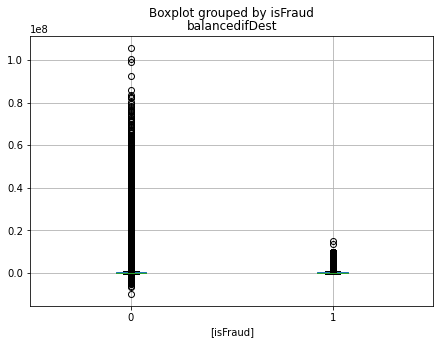

In [75]:
df_1[['balancedifDest', 'isFraud']].boxplot(by='isFraud', figsize=(7,5));

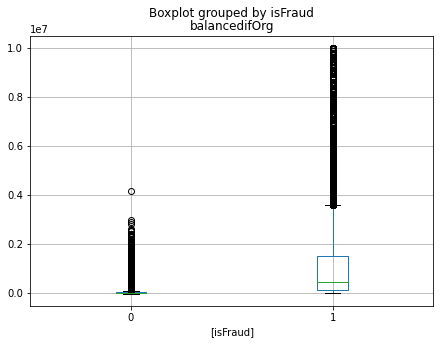

In [76]:
df_1[['balancedifOrg', 'isFraud']].boxplot(by='isFraud', figsize=(7,5));

Firstly the type of transaction is one of the key factor to detect a fraudulent case, secondly the balancedifOrg is one of the key factor, as sum equivalent to total sum in account is transactioned in fraudulent cases.

==============================================================================================